## Deconvolution Systems Design updated with rlgc 

In this example we we will create a simulated image which we will use as a test image for both rltv deconvolution and rlgc deconvolution. 

The latest version of rlgc deconvolution is available [here](https://colab.research.google.com/drive/1mfVNSCaYHz1g56g92xBkIoa8190XNJpJ)

###  Design trade-offs

RLGC is a parameter-free approach to deconvolution.  Traditionally in deconvolution there are several 'design' decisions (ie choice of parameters) to be made. 

1.  Iterations - more iterations provide a better result up to a point of diminishing returns.  How do we know when to stop? 
2.  PSF size - Using a larger PSF may improve deconvolution quality by increasing the spatial extent of the deblurring.  However a larger PSF size requires larger borders and larger overlap between chunks.  Note that the PSF size may be 'infinite' in thoeory (light from an emitter can propagate forever) however PSFs used for deconvolution are finite.  Thus the size of PSF used for deconvolution becomes a design parameter.
3.  Regularization - regularization can reduce noise in the output at a cost of slightly increased speed.  How do we know what regularization factor to use?  For the total variation regularization it is recommended to use values between 0.0001 and 0.005 [see this paper](https://pubmed.ncbi.nlm.nih.gov/16586486/) but the exact value can depend on the SNR of the image. 
4.  PSF - The quality of the Point Spread Function can affect final results.  If using a theoretical PSF we need to make sure the parameters used to generate the PSF match the true system parameters.
4.  Overlap - Larger overlaps will reduce artifacts, but increase processing time and memory by increasing the size of each chunk. 

### Simulation

In this example we do the following.

1.  Create a simulated image with a large sphere at the center and small spheres above and below.  

2.  Convolve a PSF with the simulated image and add noise.  

3.  Define our deconvolution parameters including PSF parameters, iterations and regularization factor then deconvolve with both rltv and rlgc deconvolution. 


# Imports 

In [21]:
import dask.array as da
from clij2fft.richardson_lucy import richardson_lucy_nc 
import numpy as np
from skimage.io import imsave, imread
import os

import sys
sys.path.append('../')

out_path = r'/home/bnorthan/images/tnia-python-images/imagesc/2025_06_22_rlgc_revisit'

from tnia.deconvolution.forward import forward
from tnia.plotting.projections import show_xyz_slice, show_xyz_max, show_xyz_slice_center, show_xy_zy_slice_center

## Create the phantom

Text(0.5, 0.98, 'Phantom')

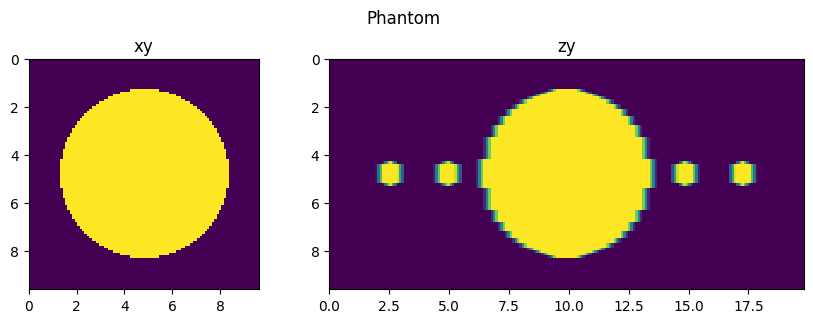

In [48]:
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large

gain = 10000
background = 100 

zdim = 196
ydim = 96
xdim = 96

x_voxel_size = 0.1
z_voxel_size=0.3

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

r=35
r_small=5
r_medium=15
size = [2*r, 2*r, 2*r]
size_small = [2*r_small, 2*r_small, 2*r_small]
size_medium = [2*r_medium, 2*r_medium, 2*r_medium]

sphere = rg.sphere(size, r).astype(np.float32)
small_sphere = rg.sphere(size_small, r_small).astype(np.float32)
medium_sphere = rg.sphere(size_medium, r_medium).astype(np.float32)


add_small_to_large(phantom, sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//2, 7*phantom.shape[0]//8)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//8)

phantom = phantom[::3,:,:]
phantom = phantom*gain
fig = show_xy_zy_slice_center(phantom, sxy=x_voxel_size, sz= z_voxel_size, figsize=(10, 3.4))
# set title
fig.suptitle('Phantom')

## Create the forward PSF and deconvolution PSF

Note that the forward PSF (the PSF that explains the image) is not equal to the digital PSF used for deconvolution.  Among other imperfect approximations the PSF used for deconvolution can have smaller spatial extent.  In this simulation the PSF we use for convolution (ie in the simulation) is different than the PSF used for deconvolution.  We can change the parameters of the deconvolution PSF to study how differences between the real PSF and the digital PSF we use for deconvolution affects the result. 

Two factors which are important but may also be only approximately known are the refractive index of the biological sample and the depth of the sample (below the cover lens).  These two factors combine to produce spherical aberration in the PSF.

If there is aberration in the true PSF of the system, to get a good deconvololution result that aberration must be matched in the sample. 

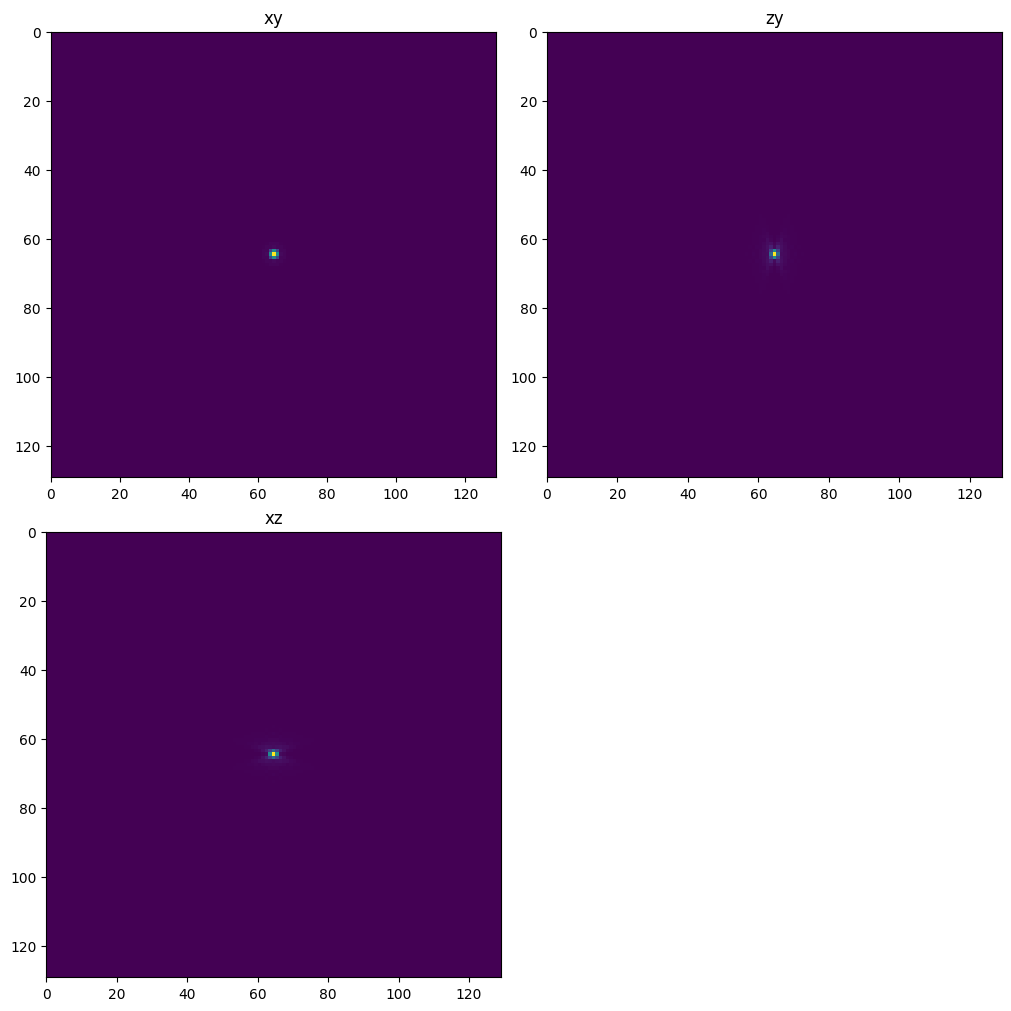

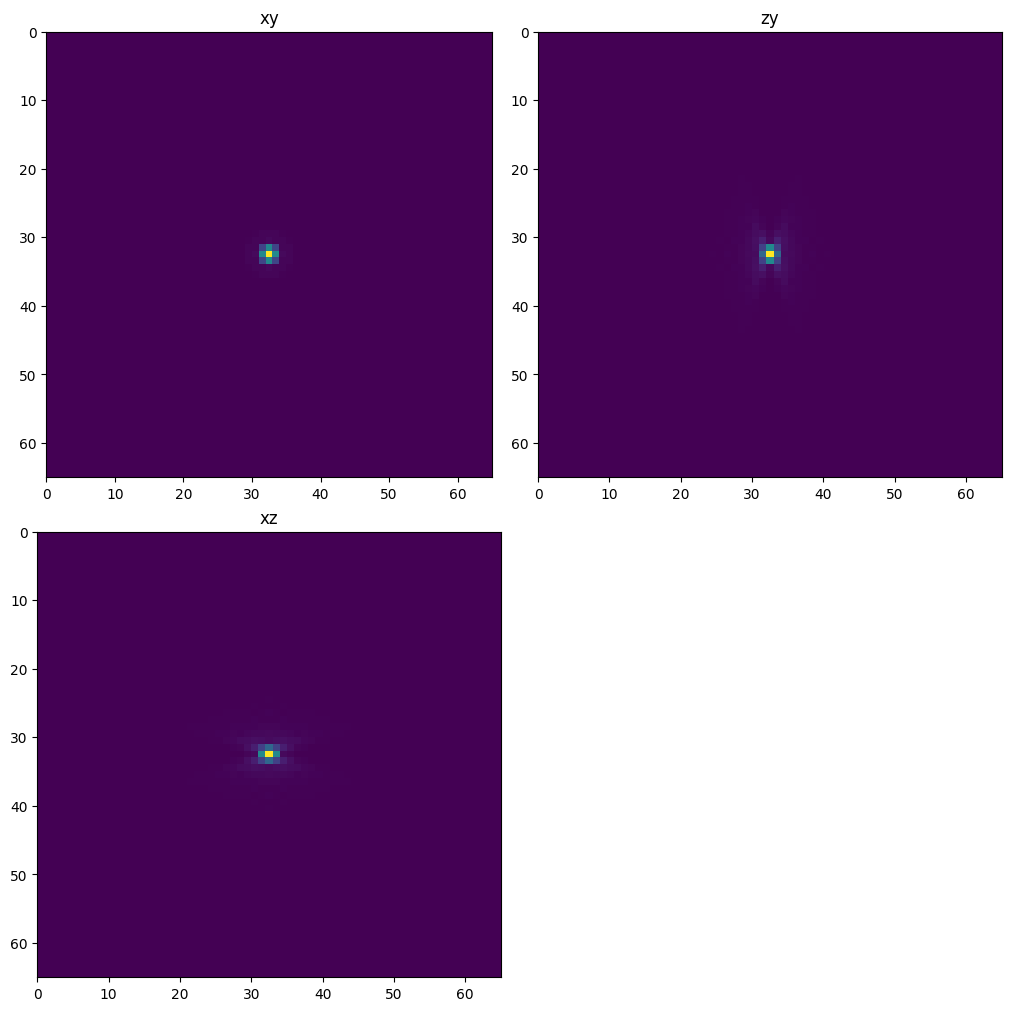

In [27]:
from tnia.deconvolution.psfs import gibson_lanni_3D


sxy = 1
sz = z_voxel_size/x_voxel_size

xy_psf_dim_forward=129
z_psf_dim_forward=129

xy_psf_dim_decon=65
z_psf_dim_decon=65

NA=1.4

# ni is the refractive index of the immersion medium of the lens
ni=1.5
# ns is the refractive index of the sample
ns=1.33

# depth at which to calculate the PSF (note if there is a RI mismatch between the lens RI and sample RI spherical aberration will be introduced
# which will be depth dependent)
#depth_forward = 10
depth_forward = 0
depth_decon = 0 

psf_forward  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_forward, z_psf_dim_forward, depth_forward, 0.5, False, True)
psf_forward = psf_forward.astype('float32')
psf_forward = psf_forward/psf_forward.sum()
fig = show_xyz_slice_center(psf_forward)

psf_decon  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_decon, z_psf_dim_decon, depth_decon, 0.5, False, True)
psf_decon = psf_decon.astype('float32')
psf_decon = psf_decon/psf_decon.sum()
fig = show_xyz_slice_center(psf_decon)

## Apply the forward model

In this case the forward model is convolution with the PSF and the addition of Poisson noise.  

What other factors will cause error between the true shape of the sample and the acquired image? 

200.0 10200.0 727971200.0
118.0 2939.0 456986020.0


Text(0.5, 0.98, 'Forward modelled image')

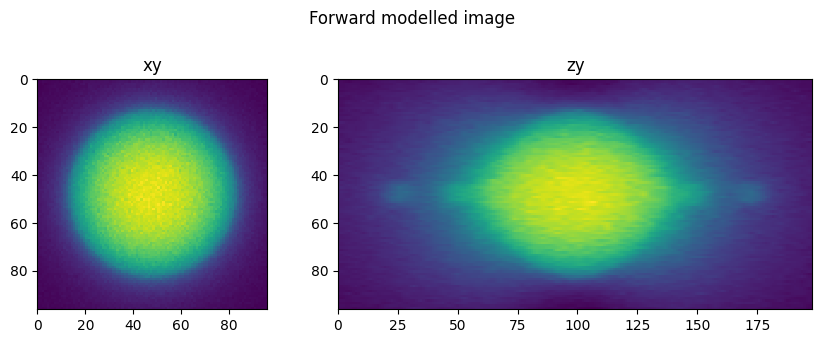

In [45]:
from tnia.deconvolution.forward import forward
from tnia.nd.ndutil import centercrop

im = forward(phantom, psf_forward, background, True, True)

x_v = im.shape[2]//2
y_v = im.shape[1]//2
z_v = im.shape[0]//2

phantom=phantom+background


print(phantom.min(), phantom.max(), phantom.sum())
print(im.min(), im.max(), im.sum())

#fig = show_xyz_slice(im, x_v, y_v, z_v, sxy=sxy, sz=sz)
fig = show_xy_zy_slice_center(im, sxy=sxy, sz=sz, figsize=(10, 3.8))
fig.suptitle('Forward modelled image')

In [29]:
psf_cropped = centercrop(psf_decon, [min(im.shape[0], psf_decon.shape[0]), psf_decon.shape[1], psf_decon.shape[2]])

In [30]:
out_phantom_name = os.path.join(out_path, 'phantom.tif')
imsave(out_phantom_name, phantom.astype(np.float32), check_contrast=False)
out_im_name = os.path.join(out_path, 'im.tif')
imsave(out_im_name, im.astype(np.float32), check_contrast=False)
out_psf_forward_name = os.path.join(out_path, 'psf_forward.tif')
imsave(out_psf_forward_name, psf_forward.astype(np.float32), check_contrast=False)
imsave(os.path.join(out_path, 'psf.tif'), psf_cropped, check_contrast=False)

In [7]:
from richardson_lucy_gradient_consensus_2025_06_22 import rlgc_latest
from richardson_lucy_gradient_consensus_noncirc_2025_06_22 import rlgc_latest_nc

total_iterations = 10000

seed = 354

recon, best_recon, stat, stop_iteration = rlgc_latest(im, psf_cropped, total_iterations, False, truth=phantom, seed=seed)
print()
recon_nc, best_recon_nc, stat_nc, stop_iteration_nc = rlgc_latest_nc(im, psf_forward, total_iterations, False, truth=phantom, seed=seed)
print()

print(stop_iteration, stop_iteration_nc)


0 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 Optimum result obtained after 150 iterations with a total time of 1.4 seconds.
160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 
510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 
1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 
1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 
2010 2020 2030 2040 2

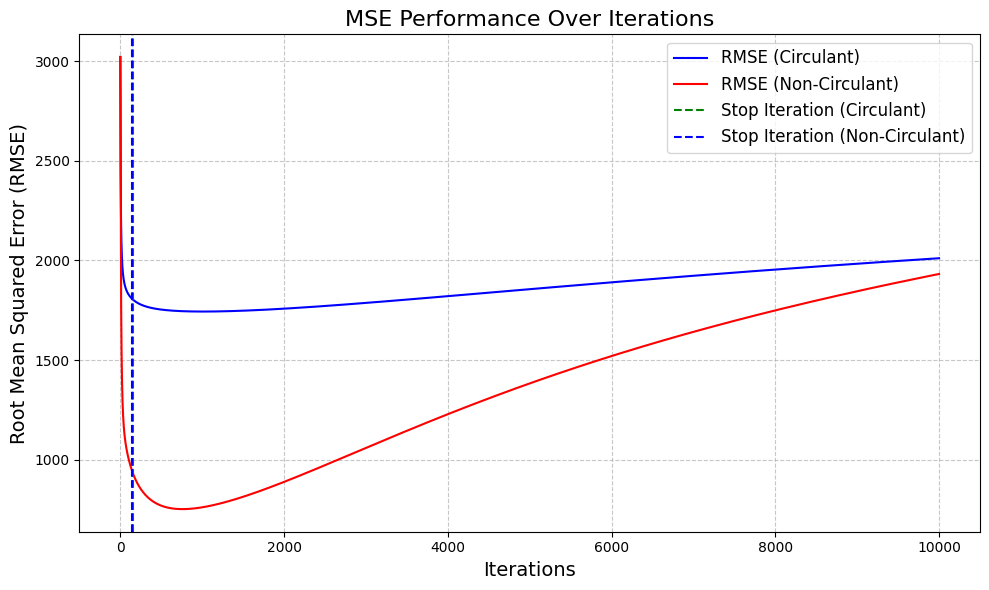

In [8]:
import matplotlib.pyplot as plt

def generate_fig(stats, stats_non_circ, stop_iteration, stop_iteration_non_circ):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the data
    ax.plot(stats['rmse'], label='RMSE (Circulant)', color='blue')
    ax.plot(stats_non_circ['rmse'], label='RMSE (Non-Circulant)', color='red')

    # Add vertical lines for stop iterations
    ax.axvline(x=stop_iteration, color='green', linestyle='--', label='Stop Iteration (Circulant)')
    ax.axvline(x=stop_iteration_non_circ, color='blue', linestyle='--', label='Stop Iteration (Non-Circulant)')

    # Add title and axis labels
    ax.set_title("MSE Performance Over Iterations", fontsize=16)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.set_ylabel("Root Mean Squared Error (RMSE)", fontsize=14)

    # Add legend
    ax.legend(fontsize=12)

    # Improve grid visibility
    ax.grid(visible=True, linestyle='--', alpha=0.7)

    # Show the
    plt.tight_layout()

    return fig

fig = generate_fig(stat, stat_nc, stop_iteration, stop_iteration_nc)

Text(0.5, 0.98, 'RLGC reconstruction nc stop_iteration=137')

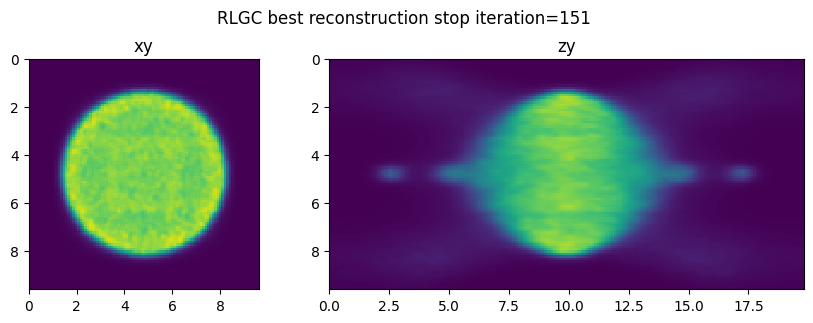

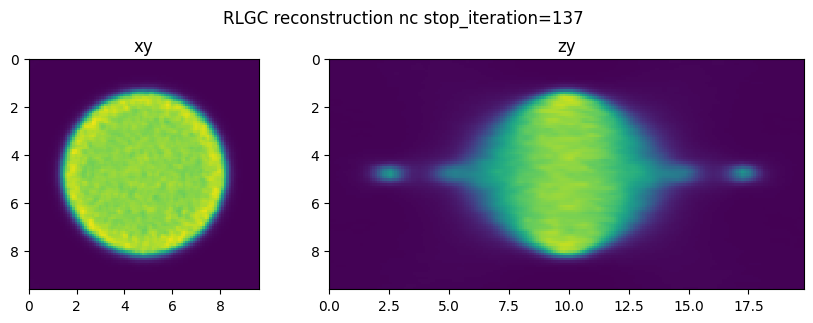

In [37]:
fig = show_xy_zy_slice_center(best_recon, sxy=x_voxel_size, sz=z_voxel_size, vmax = best_recon.max(), figsize=(10, 3.4))
fig.suptitle(f'RLGC best reconstruction stop iteration={stop_iteration}')

fig = show_xy_zy_slice_center(best_recon_nc, sxy=x_voxel_size, sz=z_voxel_size, vmax = best_recon_nc.max(), figsize=(10, 3.4))
fig.suptitle(f'RLGC reconstruction nc stop_iteration={stop_iteration_nc}')

Text(0.5, 0.98, 'RLGC nc iteration=10000')

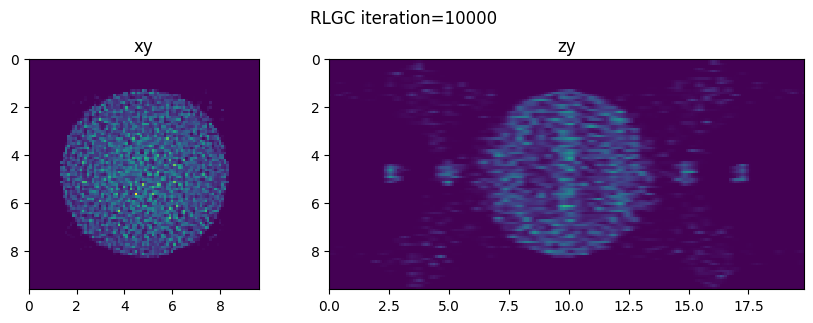

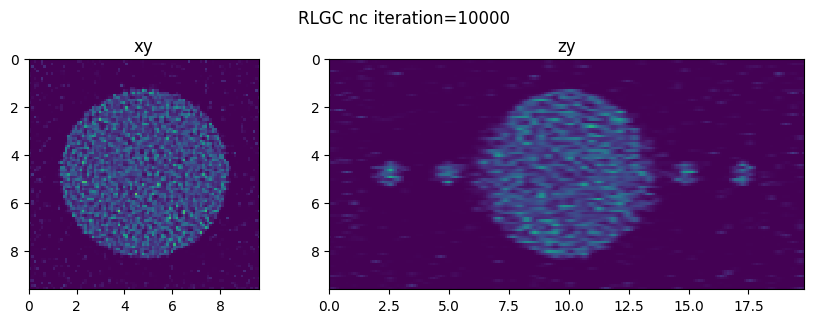

In [44]:

fig = show_xy_zy_slice_center(recon, sxy=x_voxel_size, sz=z_voxel_size, vmax = recon.max(), figsize=(10, 3.4))
fig.suptitle(f'RLGC iteration={total_iterations}')

fig = show_xy_zy_slice_center(recon_nc, sxy=x_voxel_size, sz=z_voxel_size, vmax = recon_nc.max(), figsize=(10, 3.4))
fig.suptitle(f'RLGC nc iteration={total_iterations}')

## Deconvolve with Richardson Lucy Total Variation Deconvolution

Here we deconvolve with rltv for 100, 1000, and 10000 iterations.  If we use regularization we can deconvolve thousands of iterations without too much (but still some) noise amplification. 

In [11]:
from clij2fft.richardson_lucy import richardson_lucy_nc, richardson_lucy

recon_clij2_rlnc_100 = richardson_lucy_nc(im, psf_forward, 100, .0001)
recon_clij2_rlnc_1000 = richardson_lucy_nc(im, psf_forward, 1000, .0001)
recon_clij2_rlnc_10000 = richardson_lucy_nc(im, psf_forward, 10000, .0001)

get lib
calling convcorr 0 0

platform 0 NVIDIA CUDA
device name 0 NVIDIA GeForce RTX 4070 Laptop GPU

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finished
get lib
calling convcorr 0 0

platform 0 NVIDIA CUDA
device name 0 NVIDIA GeForce RTX 4070 Laptop GPU

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 
Richardson Lucy Finished
get lib
calling convcorr 0 0

platform 0 NVIDIA CUDA
device name 0 NVIDIA GeForce RTX 4070 Laptop GPU

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 

In [12]:
from errors import RMSE

print(f'RMSE rlnctv 100: {RMSE(recon_clij2_rlnc_100, phantom)}')
print(f'RMSE rlnctv 1000: {RMSE(recon_clij2_rlnc_1000, phantom)}')
print(f'RMSE rlnctv 10000: {RMSE(recon_clij2_rlnc_10000, phantom)}')

RMSE rlnctv 100: 1005.0299682617188
RMSE rlnctv 1000: 673.6907958984375
RMSE rlnctv 10000: 735.3196411132812


Text(0.5, 0.98, 'CLIJ2 RLTVNC 10000 iterations')

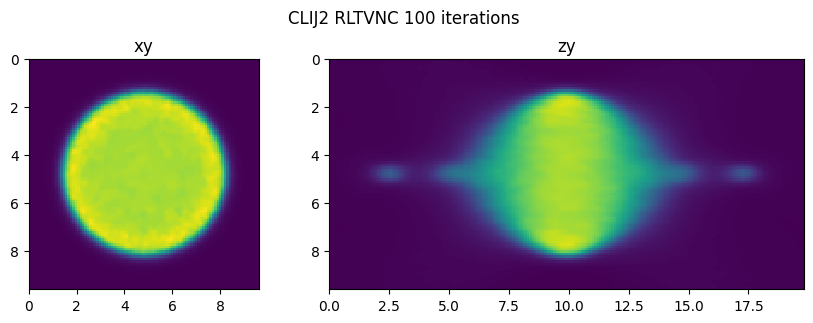

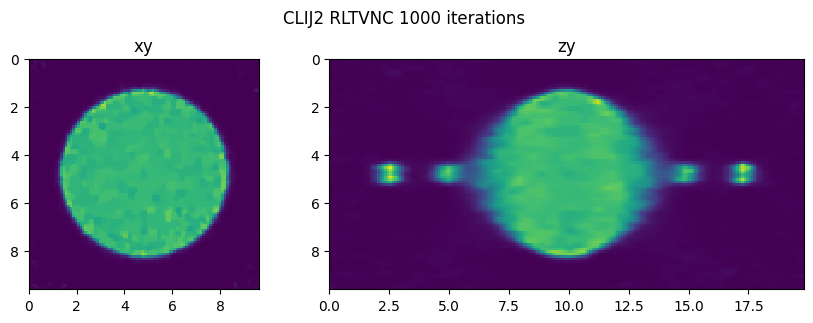

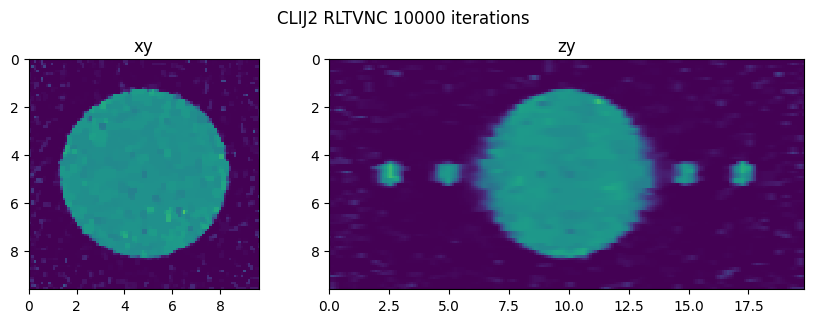

In [39]:

fig = show_xy_zy_slice_center(recon_clij2_rlnc_100, sxy=x_voxel_size, sz=z_voxel_size, vmax = recon_clij2_rlnc_100.max(), figsize=(10, 3.4))
fig.suptitle('CLIJ2 RLTVNC 100 iterations')
fig = show_xy_zy_slice_center(recon_clij2_rlnc_1000, sxy=x_voxel_size, sz=z_voxel_size, vmax = recon_clij2_rlnc_1000.max(), figsize=(10, 3.4))
fig.suptitle('CLIJ2 RLTVNC 1000 iterations')
fig = show_xy_zy_slice_center(recon_clij2_rlnc_10000, sxy=x_voxel_size, sz=z_voxel_size, vmax = recon_clij2_rlnc_10000.max(), figsize=(10, 3.4))
fig.suptitle('CLIJ2 RLTVNC 10000 iterations')

Text(0.5, 0.98, 'RLTVNC 10000 thresholded')

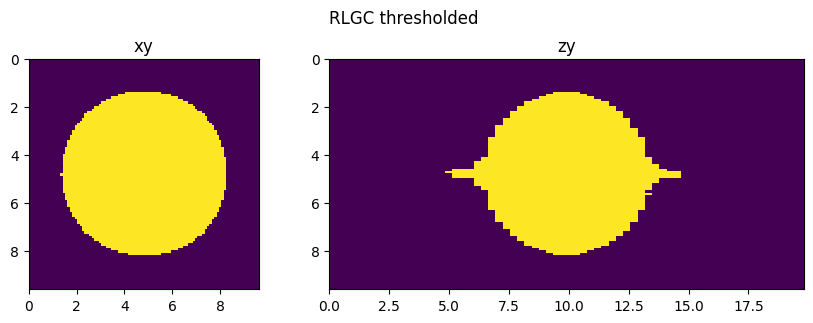

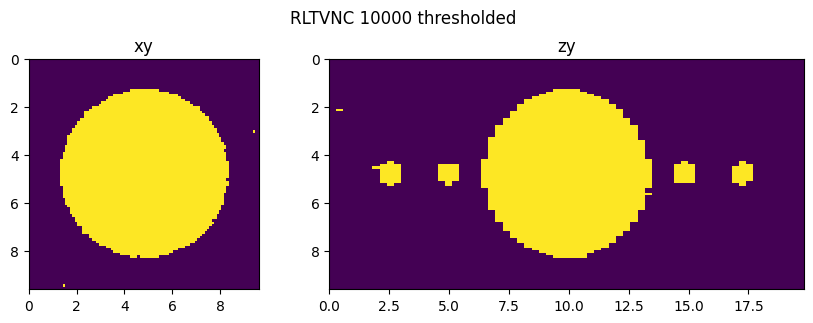

In [42]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(best_recon)
thresholded_rlgc = best_recon > thresh
fig = show_xy_zy_slice_center(thresholded_rlgc, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10, 3.4))
fig.suptitle('RLGC thresholded')

thresh = threshold_otsu(recon_clij2_rlnc_10000)
thresholded_rlnc_10000 = recon_clij2_rlnc_10000 > thresh
fig = show_xy_zy_slice_center(thresholded_rlnc_10000, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10, 3.4))
fig.suptitle('RLTVNC 10000 thresholded')

## View in Napari

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(phantom, name='phantom')
viewer.add_image(im, name='forward')
viewer.add_image(best_recon, name='best_recon')
viewer.add_image(recon, name='recon')
viewer.add_image(thresholded_rlgc, name='thresholded_rlgc')
#viewer.add_image(recon_clij2_rl_1000, name='recon clij2_rl 1000')
viewer.add_image(recon_clij2_rlnc_100, name='recon clij2_rlnc')# import otsu from skimage
viewer.add_image(recon_clij2_rlnc_1000, name='recon clij2_rlnc 1000')
viewer.add_image(recon_clij2_rlnc_10000, name='recon clij2_rlnc 10000')
viewer.add_image(thresholded_rlnc_10000, name='thresholded')

<Image layer 'thresholded' at 0x726e887d8f80>

## Look at error

In [15]:
from tnia.metrics.errors import RMSE

print('RMSE (phantom, phantom)', RMSE(phantom, phantom))
print('RMSE (phantom, im)', RMSE(phantom, im))
print(f'RMSE (phantom, rlgc {total_iterations})', RMSE(phantom, recon))
print(f'RMSE (phantom, rlgc {stop_iteration} iterations (best) )', RMSE(phantom, best_recon))
print(f'RMSE (phantom, rlgcnc {total_iterations})', RMSE(phantom, recon_nc))
print(f'RMSE (phantom, rlgcnc {stop_iteration_nc} (best) )', RMSE(phantom, best_recon_nc))
print('RMSE (phantom, rltvnc 100)', RMSE(phantom, recon_clij2_rlnc_100))
print('RMSE (phantom, rltvnc 1000)', RMSE(phantom, recon_clij2_rlnc_1000))
print('RMSE (phantom, rltvnc 10000)', RMSE(phantom, recon_clij2_rlnc_10000))

RMSE (phantom, phantom) 0.0
RMSE (phantom, im) 2595.4453
RMSE (phantom, rlgc 10000) 2010.9445
RMSE (phantom, rlgc 151 iterations (best) ) 1804.7213
RMSE (phantom, rlgcnc 10000) 1932.0444
RMSE (phantom, rlgcnc 137 (best) ) 952.9012
RMSE (phantom, rltvnc 100) 1005.02997
RMSE (phantom, rltvnc 1000) 673.6908
RMSE (phantom, rltvnc 10000) 735.31964


## Segment the spheres

In [16]:
# import otsu
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

def segmenter(im, min_area=0):
    
    binary = im>threshold_otsu(im)
    labels = label(binary) 
    
    # get the regions
    object_list = regionprops(labels,im)

    filtered_objects = []
    labels_filtered = np.zeros_like(labels)

    if min_area==0:
        return object_list, labels
    
    else:
        for obj in object_list:
            
            if obj.area > min_area:
                labels_filtered[labels==obj.label]=obj.label
                filtered_objects.append(obj)
        return filtered_objects, labels_filtered

In [17]:
objects_truth, labels_truth = segmenter(phantom, 20)
objects_im, labels_im = segmenter(im, 20)
objects_best_recon, labels_best_recon = segmenter(best_recon, 20)   
objects_recon, labels_recon = segmenter(recon, 20)
objects_clij2_rlnc_100, labels_clij2_rlnc_100 = segmenter(recon_clij2_rlnc_100, 20)
objects_clij2_rlnc_1000, labels_clij2_rlnc_1000 = segmenter(recon_clij2_rlnc_1000, 20)
objects_clij2_rlnc_10000, labels_clij2_rlnc_10000 = segmenter(recon_clij2_rlnc_10000, 20)


print('objects_truth', len(objects_truth))
print('objects_im', len(objects_im))
print('objects_best_recon', len(objects_best_recon))
print('objects_recon', len(objects_recon))
print('objects_clij2_rlnc_100', len(objects_clij2_rlnc_100))
print('objects_clij2_rlnc_1000', len(objects_clij2_rlnc_1000))
print('objects_clij2_rlnc_10000', len(objects_clij2_rlnc_10000))

objects_truth 5
objects_im 1
objects_best_recon 1
objects_recon 5
objects_clij2_rlnc_100 1
objects_clij2_rlnc_1000 5
objects_clij2_rlnc_10000 5


## Make figures of segmentations

Text(0.5, 0.98, 'CLIJ2 RLTVNC 10000 iterations Segmented')

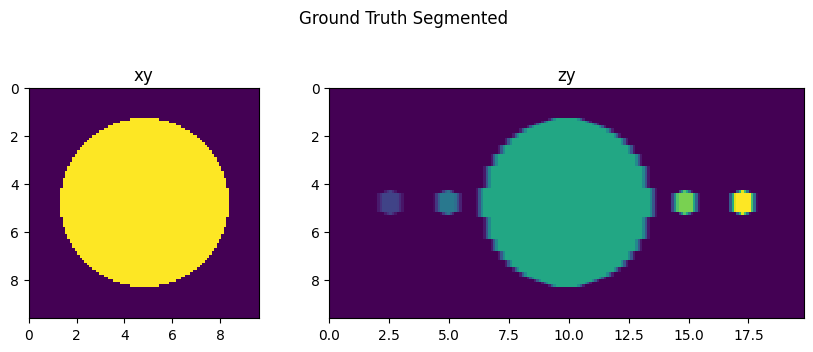

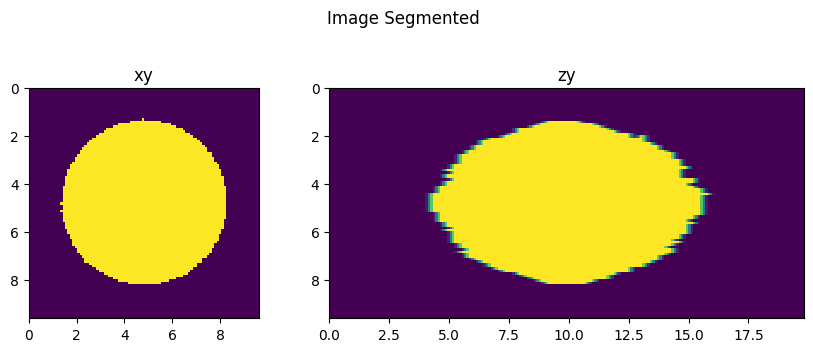

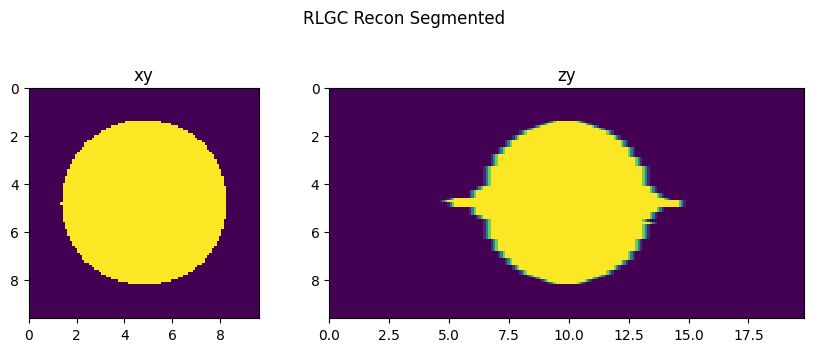

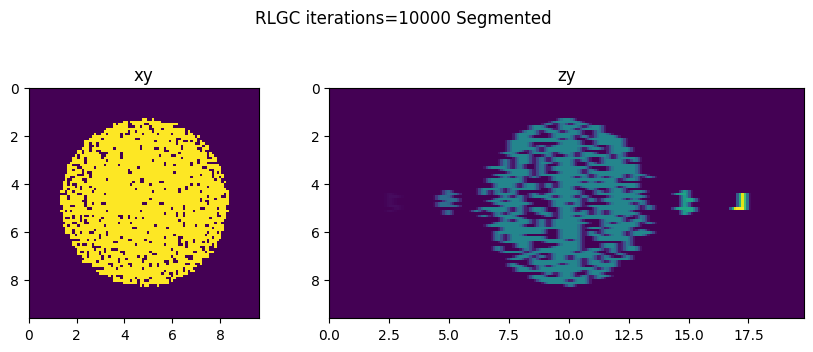

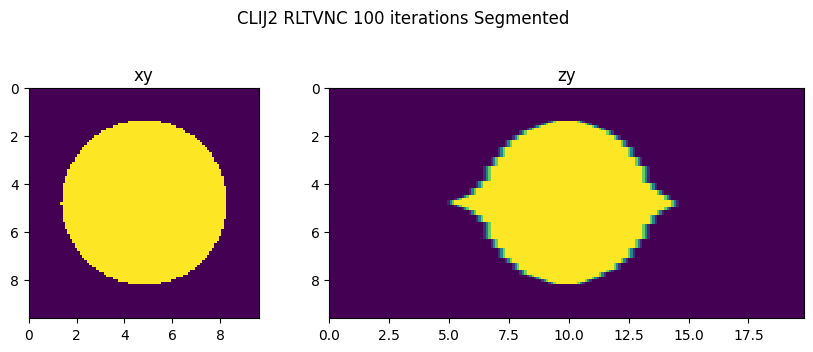

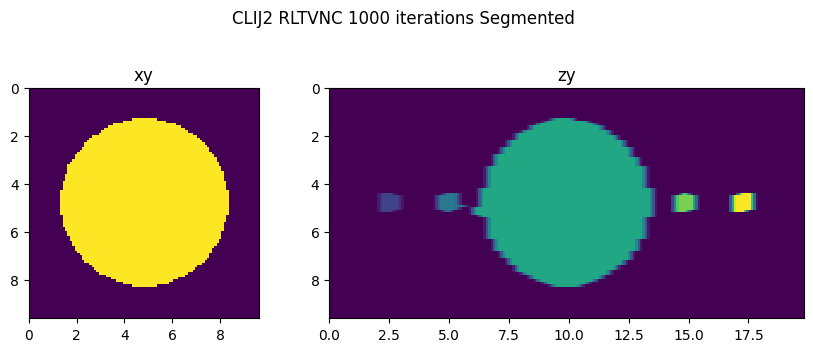

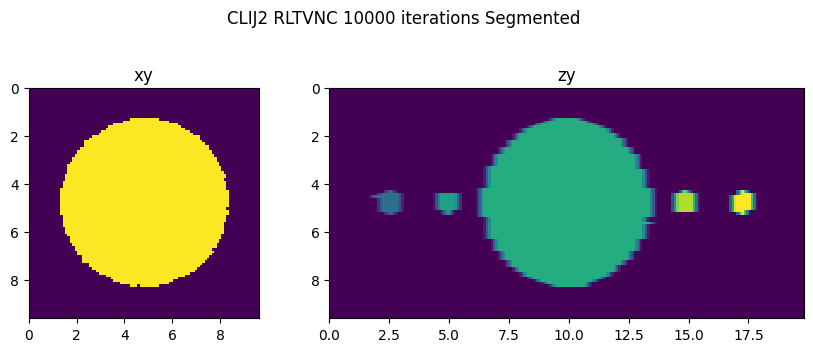

In [43]:
from tnia.plotting.plt_helper import random_label_cmap

fig = show_xy_zy_slice_center(labels_truth, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10,4))
fig.suptitle('Ground Truth Segmented')
fig = show_xy_zy_slice_center(labels_im, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10,4))
fig.suptitle('Image Segmented')
fig = show_xy_zy_slice_center(labels_best_recon, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10,4))
fig.suptitle('RLGC Recon Segmented')
fig = show_xy_zy_slice_center(labels_recon, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10,4))
fig.suptitle(f'RLGC iterations={total_iterations} Segmented')
fig = show_xy_zy_slice_center(labels_clij2_rlnc_100, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10,4))
fig.suptitle('CLIJ2 RLTVNC 100 iterations Segmented')
fig = show_xy_zy_slice_center(labels_clij2_rlnc_1000, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10,4))
fig.suptitle('CLIJ2 RLTVNC 1000 iterations Segmented')
fig = show_xy_zy_slice_center(labels_clij2_rlnc_10000, sxy=x_voxel_size, sz=z_voxel_size, figsize=(10,4))
fig.suptitle('CLIJ2 RLTVNC 10000 iterations Segmented')

## Segmentation results

In [19]:
def print_objects(objects):
    for obj in objects:
        print(f'Object {obj.label}: Area = {obj.area}, Mean Intensity = {obj.mean_intensity}')
    print()

print_objects(objects_truth)
'''
print_objects(objects_im)
print_objects(objects_best_recon)
print_objects(objects_recon)
print_objects(objects_clij2_rlnc_100)
print_objects(objects_clij2_rlnc_1000)
'''
print_objects(objects_clij2_rlnc_1000)
print_objects(objects_clij2_rlnc_10000)

Object 1: Area = 184.0, Mean Intensity = 10100.0
Object 2: Area = 184.0, Mean Intensity = 10100.0
Object 3: Area = 59896.0, Mean Intensity = 10100.0009765625
Object 4: Area = 184.0, Mean Intensity = 10100.0
Object 5: Area = 184.0, Mean Intensity = 10100.0

Object 1: Area = 146.0, Mean Intensity = 8796.072265625
Object 2: Area = 124.0, Mean Intensity = 7670.7119140625
Object 3: Area = 58175.0, Mean Intensity = 9629.7890625
Object 4: Area = 119.0, Mean Intensity = 7700.0673828125
Object 5: Area = 141.0, Mean Intensity = 9002.8017578125

Object 203: Area = 178.0, Mean Intensity = 9322.6728515625
Object 315: Area = 170.0, Mean Intensity = 8831.30859375
Object 342: Area = 59210.0, Mean Intensity = 9869.484375
Object 486: Area = 165.0, Mean Intensity = 8808.4501953125
Object 552: Area = 172.0, Mean Intensity = 9598.314453125



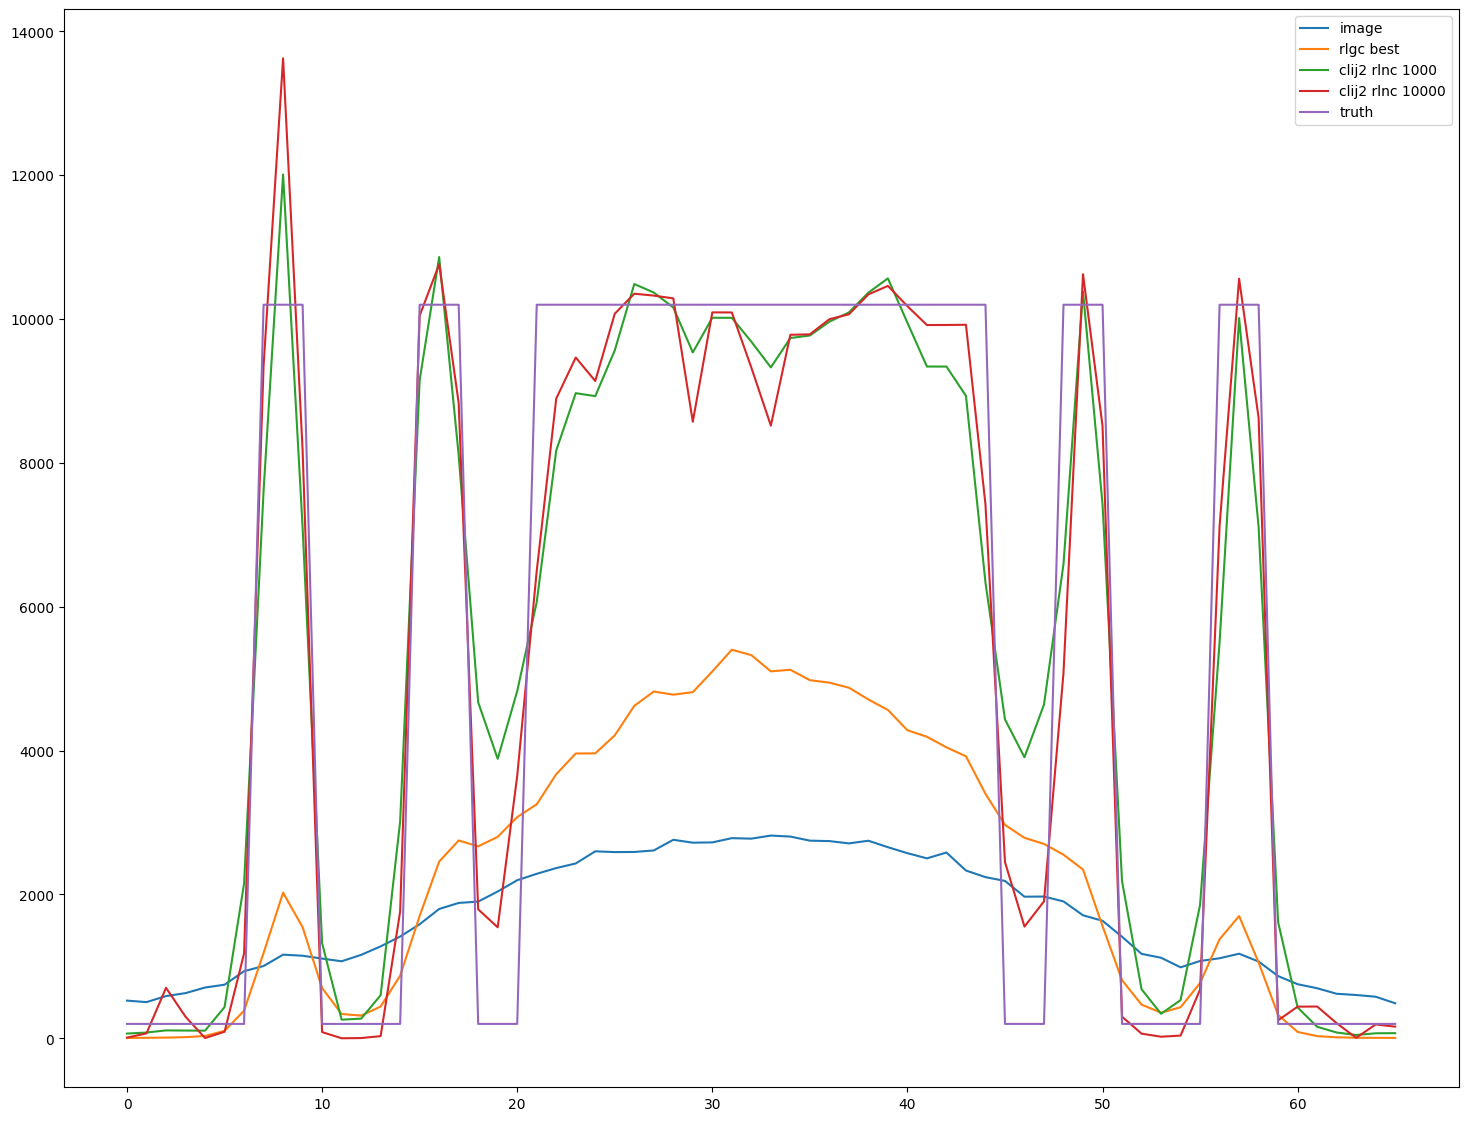

In [46]:
import matplotlib.pyplot as plt
s=im.shape

fig, ax = plt.subplots(figsize=(18,14)) 

line_z=int(s[0]//2)
line_y=int(s[1]//2)
line_x=int(s[2]//2)

index = np.s_[:, line_y, line_x]

line=im[index]
ax.plot(line, label = 'image')

line=best_recon[index]
ax.plot(line, label='rlgc best')

line=recon[index]
#ax.plot(line, label=f'rlgc {total_iterations}')

#line=recon_clij2_rlnc_100[index]
#ax.plot(line, label='clij2 rlnc 100')

line=recon_clij2_rlnc_1000[index]
ax.plot(line, label='clij2 rlnc 1000')

line=recon_clij2_rlnc_10000[index]
ax.plot(line, label='clij2 rlnc 10000')

line=phantom[index]
ax.plot(line, label='truth')

ax.legend()